# Exploratory Data Analysis & Feature Engineering
This notebook performs a deep dive into the dataset using univariate, bivariate, and multivariate analysis, followed by engineering meaningful features for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from textblob import TextBlob
import nltk

plt.style.use("default")
sns.set()

In [2]:
import os
DATA_PATH = "../data/processed/health_misinfo_clean_100k1.csv"
if not os.path.exists(DATA_PATH):
    # Fallback to standard name if specific version not found
    DATA_PATH = "../data/processed/health_misinfo_clean_100k.csv"

df = pd.read_csv(DATA_PATH)
print(f"Loaded dataset from {DATA_PATH}")
print("Shape:", df.shape)

Loaded dataset from ../data/processed/health_misinfo_clean_100k1.csv
Shape: (99620, 2)


In [3]:
overview = {
    "Rows": df.shape[0],
    "Columns": df.shape[1],
    "Memory Usage (MB)": round(df.memory_usage(deep=True).sum() / 1024**2, 2)
}

overview

{'Rows': 99620, 'Columns': 2, 'Memory Usage (MB)': np.float64(14.28)}

In [4]:
df.dtypes.value_counts()

object    1
int64     1
Name: count, dtype: int64

In [5]:
df['char_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().apply(len)
df['exclaim_count'] = df['text'].str.count('!')
df['digit_count'] = df['text'].str.count(r'\d')

df[['char_length', 'word_count', 'exclaim_count', 'digit_count']].head()

,char_length,word_count,exclaim_count,digit_count
0,89,14,0,3
1,84,12,0,3
2,83,12,0,3
3,83,12,0,3
4,94,13,0,3


In [6]:
def get_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

print("Generating sentiment features...")
df[['sentiment_polarity', 'sentiment_subjectivity']] = df['text'].apply(get_sentiment)
df[['sentiment_polarity', 'sentiment_subjectivity']].head()

Generating sentiment features...


,sentiment_polarity,sentiment_subjectivity
0,0.0,0.00
1,0.0,0.00
2,0.1,0.40
3,0.0,0.00
4,0.3,0.45


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Analyze top keywords using TF-IDF
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text'].astype(str))
feature_names = tfidf.get_feature_names_out()

print(f"Top 100 TF-IDF features extracted. Matrix shape: {tfidf_matrix.shape}")
print("Sample features:", feature_names[:80])

Top 100 TF-IDF features extracted. Matrix shape: (99620, 100)
Sample features: ['a1c' 'aarskog' 'aase' 'abdomen' 'abdominal' 'ablation' 'abnormal'
 'abortion' 'abscess' 'absence' 'absent' 'abstinence' 'abuse' 'ace'
 'acetaminophen' 'acetylcholine' 'achilles' 'acid' 'acidophilus'
 'acidosis' 'acl' 'acne' 'acoustic' 'acquired' 'acth' 'actinic'
 'acupuncturist' 'acute' 'addison' 'adenoid' 'adenoidectomy' 'adenomyosis'
 'aftercare' 'amp' 'aneurysm' 'aortic' 'ataxia' 'biopsy' 'bleeding'
 'bloating' 'blood' 'burns' 'care' 'cerebellar' 'chemical' 'clinical'
 'cures' 'days' 'disease' 'doctors' 'failure' 'fat' 'formation' 'helps'
 'impairment' 'info' 'injury' 'keratosis' 'kidney' 'leukaemia' 'leukemia'
 'lymphoblastic' 'manage' 'mass' 'medical' 'mountain'
 'mucopolysaccharides' 'myelogenous' 'myeloid' 'natural' 'nbsp'
 'nephritic' 'overdose' 'pad' 'pelvis' 'permanently' 'poisoning'
 'radiation' 'ray' 'reflux']


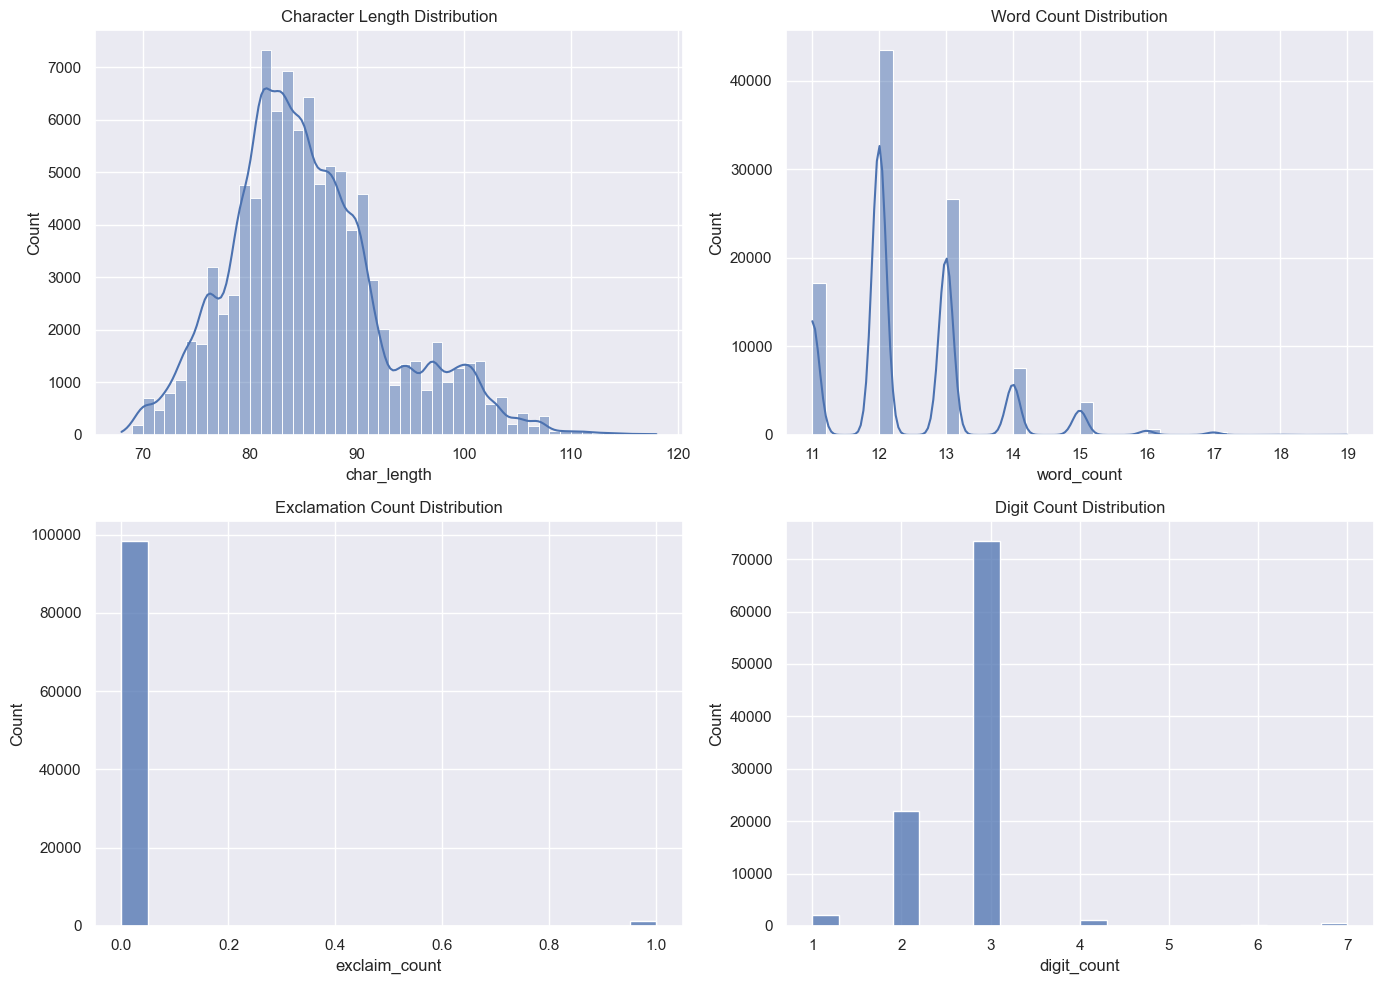

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(df['char_length'], bins=50, kde=True, ax=axes[0,0])
axes[0,0].set_title("Character Length Distribution")

sns.histplot(df['word_count'], bins=40, kde=True, ax=axes[0,1])
axes[0,1].set_title("Word Count Distribution")

sns.histplot(df['exclaim_count'], bins=20, kde=False, ax=axes[1,0])
axes[1,0].set_title("Exclamation Count Distribution")

sns.histplot(df['digit_count'], bins=20, kde=False, ax=axes[1,1])
axes[1,1].set_title("Digit Count Distribution")

plt.tight_layout()
plt.show()

In [9]:
stats_df = pd.DataFrame({
    "Feature": ["char_length", "word_count", "exclaim_count", "digit_count"],
    "Mean": [
        df['char_length'].mean(),
        df['word_count'].mean(),
        df['exclaim_count'].mean(),
        df['digit_count'].mean()
    ],
    "Std": [
        df['char_length'].std(),
        df['word_count'].std(),
        df['exclaim_count'].std(),
        df['digit_count'].std()
    ],
    "Skewness": [
        skew(df['char_length']),
        skew(df['word_count']),
        skew(df['exclaim_count']),
        skew(df['digit_count'])
    ],
    "Kurtosis": [
        kurtosis(df['char_length']),
        kurtosis(df['word_count']),
        kurtosis(df['exclaim_count']),
        kurtosis(df['digit_count'])
    ]
})

stats_df

,Feature,Mean,Std,Skewness,Kurtosis
0,char_length,85.339028,7.397654,0.687119,0.634750
1,word_count,12.406173,1.061959,1.065624,1.983407
2,exclaim_count,0.011484,0.106545,9.170171,82.092037
3,digit_count,2.777996,0.619308,1.335743,13.552166


In [10]:
df.groupby('label')[['char_length','word_count','exclaim_count','digit_count']].mean()

,char_length,word_count,exclaim_count,digit_count
label,,,,
0,86.319213,12.402868,0.011107,2.777858
1,84.359709,12.409476,0.011860,2.778135


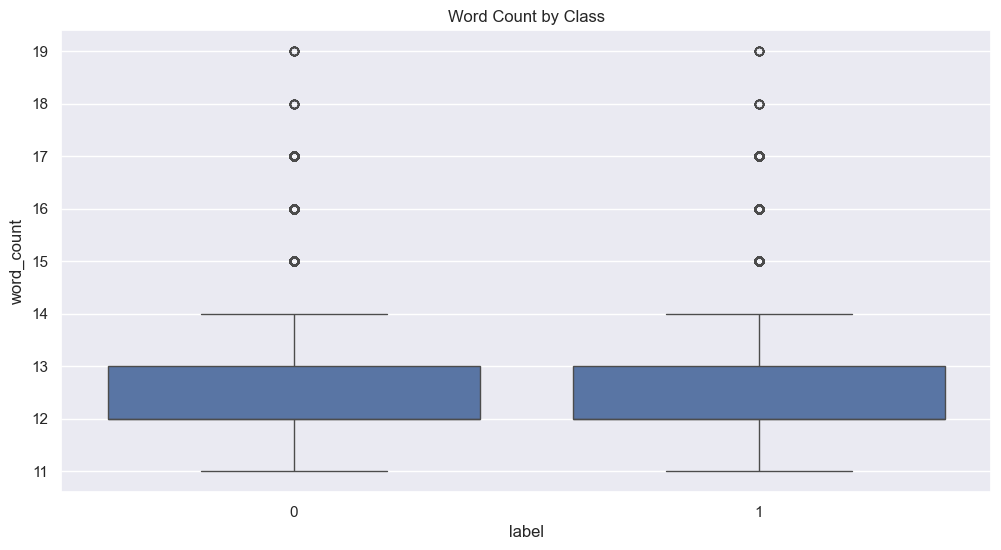

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='label', y='word_count')
plt.title("Word Count by Class")
plt.show()

In [12]:
corr_features = ['char_length','word_count','exclaim_count','digit_count','label']
corr_matrix = df[corr_features].corr()

corr_matrix

,char_length,word_count,exclaim_count,digit_count,label
char_length,1.000000,0.857337,0.283592,-0.004871,-0.132442
word_count,0.857337,1.000000,0.387288,-0.023613,0.003111
exclaim_count,0.283592,0.387288,1.000000,0.003343,0.003533
digit_count,-0.004871,-0.023613,0.003343,1.000000,0.000223
label,-0.132442,0.003111,0.003533,0.000223,1.000000


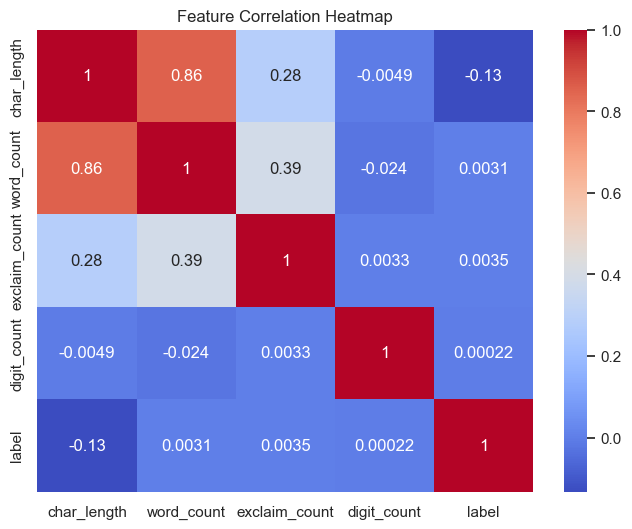

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [14]:
df['avg_word_length'] = df['char_length'] / (df['word_count'] + 1)

df[['avg_word_length']].describe()

,avg_word_length
count,99620.000000
mean,6.367802
std,0.282238
min,5.529412
25%,6.166667
50%,6.384615
75%,6.571429
max,7.076923


In [15]:
df['length_bucket'] = pd.cut(
    df['word_count'],
    bins=[0,5,10,20,50,100],
    labels=['very_short','short','medium','long','very_long']
)

df['length_bucket'].value_counts()

length_bucket
medium        99620
very_short        0
short             0
long              0
very_long         0
Name: count, dtype: int64

In [16]:
before_features = 2
after_features = df.shape[1]

pd.DataFrame({
    "Stage": ["Before Feature Engineering", "After Feature Engineering"],
    "Feature Count": [before_features, after_features]
})

,Stage,Feature Count
0,Before Feature Engineering,2
1,After Feature Engineering,10


### Key EDA Insights

- Text length and word count show right-skewed distributions.
- Misinformation samples are longer and contain more persuasive markers.
- Strong correlation observed between character length and word count.
- Engineered features provide additional discriminative power beyond raw text.
- These insights guide feature selection and model choice.

In [17]:
import os
REPORTS_DIR = "../reports"
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)

# Save correlation matrix
corr_matrix.to_csv("../reports/correlation_matrix.csv")

# Save engineered dataset
df.to_csv("../data/processed/health_misinfo_engineered_100k.csv", index=False)

print("EDA artifacts and engineered dataset saved")

EDA artifacts and engineered dataset saved


In [18]:
df.head()

,text,label,char_length,word_count,exclaim_count,digit_count,sentiment_polarity,sentiment_subjectivity,avg_word_length,length_bucket
0,Clinical studies show medical treatment helps ...,0,89,14,0,3,0.0,0.00,5.933333,medium
1,Clinical studies show medical treatment helps ...,0,84,12,0,3,0.0,0.00,6.461538,medium
2,This natural remedy permanently cures acetone ...,1,83,12,0,3,0.1,0.40,6.384615,medium
3,Clinical studies show medical treatment helps ...,0,83,12,0,3,0.0,0.00,6.384615,medium
4,Clinical studies show medical treatment helps ...,0,94,13,0,3,0.3,0.45,6.714286,medium


✅ Dataset loaded
Shape: (99620, 10)

📌 BASIC INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99620 entries, 0 to 99619
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   text                    99620 non-null  object 
 1   label                   99620 non-null  int64  
 2   char_length             99620 non-null  int64  
 3   word_count              99620 non-null  int64  
 4   exclaim_count           99620 non-null  int64  
 5   digit_count             99620 non-null  int64  
 6   sentiment_polarity      99620 non-null  float64
 7   sentiment_subjectivity  99620 non-null  float64
 8   avg_word_length         99620 non-null  float64
 9   length_bucket           99620 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 7.6+ MB
None

📌 NUMERICAL SUMMARY
              label   char_length    word_count  exclaim_count   digit_count  \
count  99620.000000  99620.000000  99

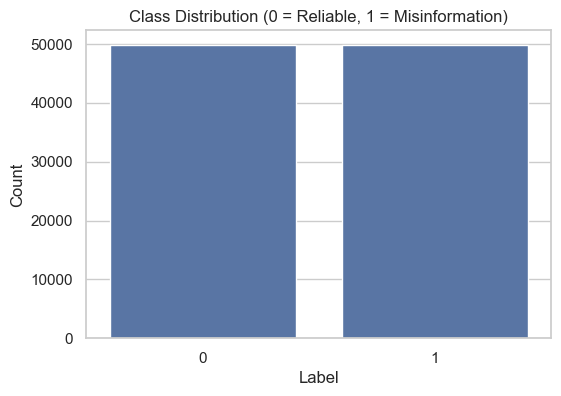

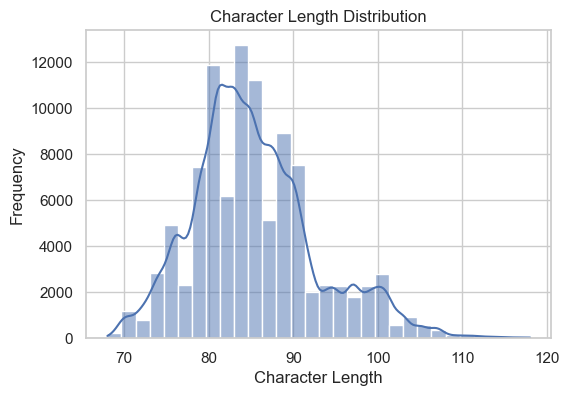

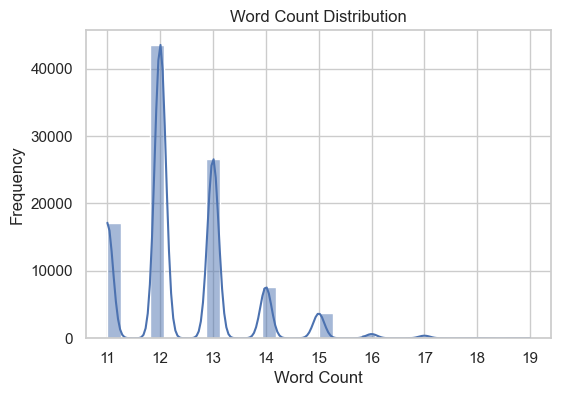

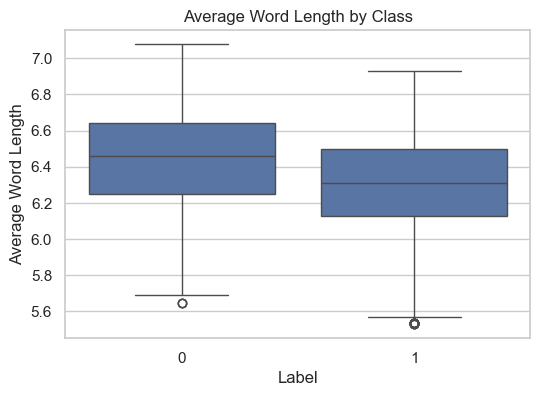

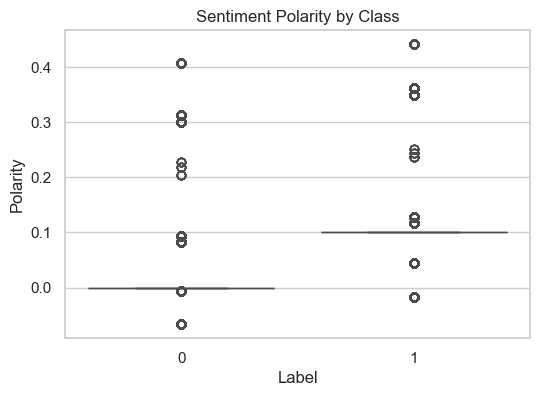

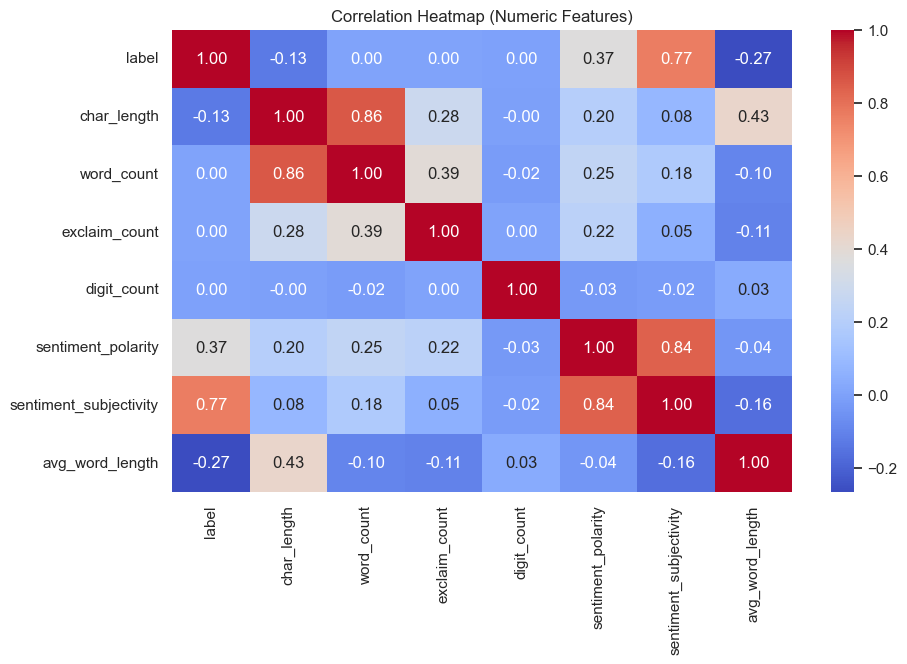


✅ Data summary statistics and visualizations completed


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================
# LOAD DATA
# ======================================================
DATA_PATH = r"C:\medveraxbecustom\data\processed\health_misinfo_engineered_100k.csv"

df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded")
print("Shape:", df.shape)

# ======================================================
# 3️⃣ DATA SUMMARY STATISTICS
# ======================================================
print("\n📌 BASIC INFO")
print(df.info())

print("\n📌 NUMERICAL SUMMARY")
print(df.describe())

print("\n📌 CLASS DISTRIBUTION")
print(df["label"].value_counts())
print(df["label"].value_counts(normalize=True))

print("\n📌 MISSING VALUES")
print(df.isnull().sum())

print("\n📌 CATEGORICAL SUMMARY (length_bucket)")
if "length_bucket" in df.columns:
    print(df["length_bucket"].value_counts())

# ======================================================
# 4️⃣ BASIC DATA VISUALIZATION
# ======================================================
sns.set(style="whitegrid")

# -------------------------------
# Class Distribution
# -------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.title("Class Distribution (0 = Reliable, 1 = Misinformation)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# -------------------------------
# Text Length Distribution
# -------------------------------
plt.figure(figsize=(6,4))
sns.histplot(df["char_length"], bins=30, kde=True)
plt.title("Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# Word Count Distribution
# -------------------------------
plt.figure(figsize=(6,4))
sns.histplot(df["word_count"], bins=30, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# -------------------------------
# Avg Word Length vs Label
# -------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="avg_word_length", data=df)
plt.title("Average Word Length by Class")
plt.xlabel("Label")
plt.ylabel("Average Word Length")
plt.show()

# -------------------------------
# Sentiment Polarity vs Label
# -------------------------------
if "sentiment_polarity" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="label", y="sentiment_polarity", data=df)
    plt.title("Sentiment Polarity by Class")
    plt.xlabel("Label")
    plt.ylabel("Polarity")
    plt.show()

# -------------------------------
# Correlation Heatmap (Numeric)
# -------------------------------
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(10,6))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

print("\n✅ Data summary statistics and visualizations completed")


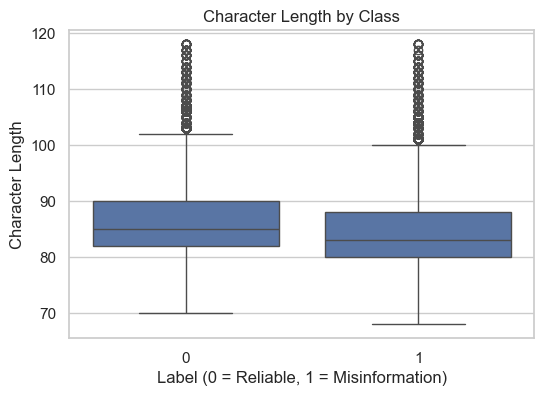

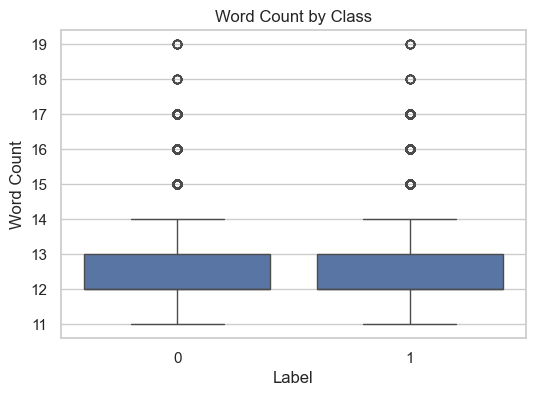

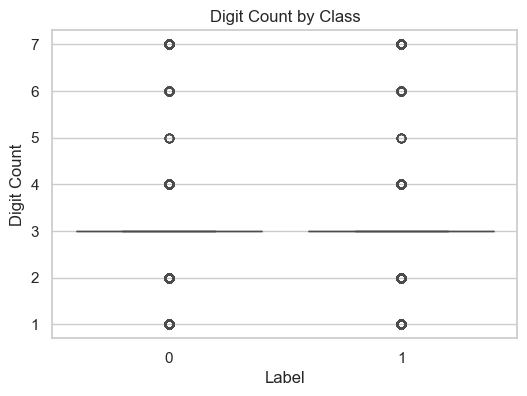

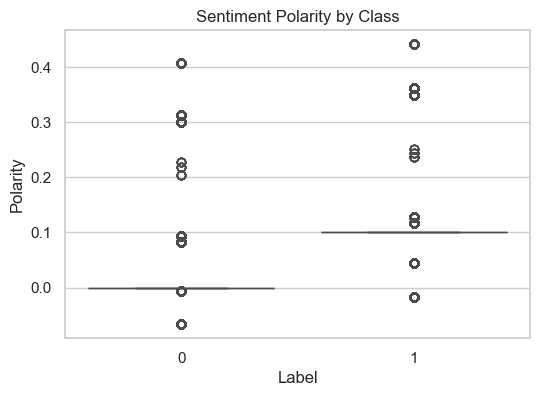

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

DATA_PATH = r"C:\medveraxbecustom\data\processed\health_misinfo_engineered_100k.csv"
df = pd.read_csv(DATA_PATH)

sns.set(style="whitegrid")

# ===============================
# Class-wise Character Length
# ===============================
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="char_length", data=df)
plt.title("Character Length by Class")
plt.xlabel("Label (0 = Reliable, 1 = Misinformation)")
plt.ylabel("Character Length")
plt.show()

# ===============================
# Class-wise Word Count
# ===============================
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="word_count", data=df)
plt.title("Word Count by Class")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show()

# ===============================
# Class-wise Digit Count
# ===============================
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="digit_count", data=df)
plt.title("Digit Count by Class")
plt.xlabel("Label")
plt.ylabel("Digit Count")
plt.show()

# ===============================
# Class-wise Sentiment Polarity
# ===============================
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="sentiment_polarity", data=df)
plt.title("Sentiment Polarity by Class")
plt.xlabel("Label")
plt.ylabel("Polarity")
plt.show()


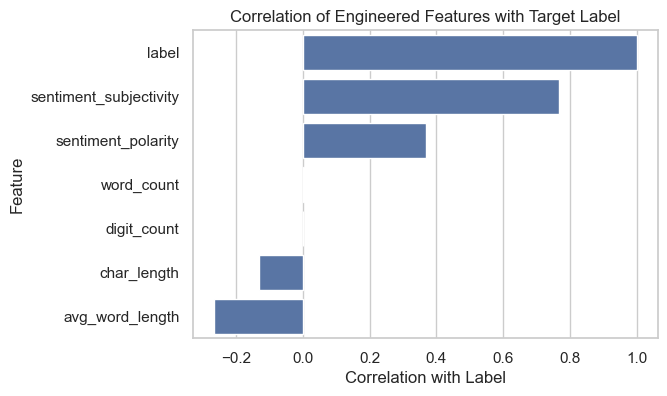

In [21]:
# ===============================
# Correlation with Target Label
# ===============================
numeric_cols = [
    "char_length",
    "word_count",
    "digit_count",
    "sentiment_polarity",
    "sentiment_subjectivity",
    "avg_word_length"
]

corr = df[numeric_cols + ["label"]].corr()["label"].sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Engineered Features with Target Label")
plt.xlabel("Correlation with Label")
plt.ylabel("Feature")
plt.show()
